## Resultados de las mediciones tomadas con el fotómetro durante el eclipse

Esto es un setup básico para graficar

In [128]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='serif')

Ahora leemos cada linea del archivo guardado

In [129]:
with open('datos.csv', 'r') as file:
    lines = file.readlines()

Guardamos los tiempo registrados y del momento de máxima oscuridad durante el eclipse en una lista

In [138]:
maximal = '14:39:32' # https://astronomia-udea.co/calendar/?type=multiple&section=eclipses#eclipse_condiciones
times = [(i, line.split(',')[0]) for i, line in enumerate(lines) if line.split(',')[0] < maximal]
print(times[0])
print(times[-1]) # ver indice inmediatamente anterior del tiempo maximo
times.append((times[-1][0]+1, maximal))
times += [(times[-1][0]+1+i, line.split(',')[0]) for i, line in enumerate(lines[times[-1][0]+1:]) if line.split(',')[0] >= maximal]    
print(times[-1]) # ver cantidad de datos -1

(0, '13:33:30')
(786, '14:39:30')
(1139, '15:09:07')


Ahora guardamos en una lista ordenada todas las mediciones

In [139]:
lux = list(map(lambda x: float(x.split(',')[1][:-1]), lines))

## Gráfica de las mediciones a lo largo del tiempo

Esta gráfica nos mostrará todos los datos sin procesar, resaltando algunos tiempos (incluyendo el esperado para el máximo segun https://astronomia-udea.co/calendar/?type=multiple&section=eclipses#eclipse_condiciones)

In [161]:
def makeScatter(times, lux, width=10, height=5, maximal=None, step=150, outliers=None):
    fig = plt.figure(figsize=[width, height])
    ax = fig.add_subplot(111)
    ax.scatter(range(len(lux)), lux, color='b', alpha=0.65)
    if outliers is not None:
        ax.scatter(outliers[:,0], outliers[:,-1], color='r', alpha=0.8)
    xticks = [(i, hhmmss) for i, hhmmss in times if i%step == 0]
    if xticks[0][0] != 0:
        xticks.append((0, times[0][-1]))
    if maximal is not None:    
        ax.vlines(maximal[0], ymin=-0.5, ymax=max(lux)+min(lux), colors='k', linestyles='dashed', label='Tiempo esperado para el máximo')
        if maximal[0] not in {i for i, _ in xticks}:
            xticks.append((787, maximal))
        ax.legend(loc='best')
    if xticks[-1][0] != times[-1][0]:
        xticks.append((times[-1][0], times[-1][-1]))
    xticks.sort(key=lambda x: x[0])
    ax.set_xticks([i for i, _ in xticks])
    ax.set_xticklabels([label for _, label in xticks], rotation=45)
    ax.set_ylim(-0.5, max(lux)+min(lux))
    ax.set_ylabel('Iluminancia (Lux)', fontsize=12)
    ax.set_xlim(xticks[0][0], xticks[-1][0])
    ax.set_xlabel('Tiempo', fontsize=12)
    ax.set_axisbelow(True)
    ax.grid(linestyle='--',color='0.7')
    plt.show()

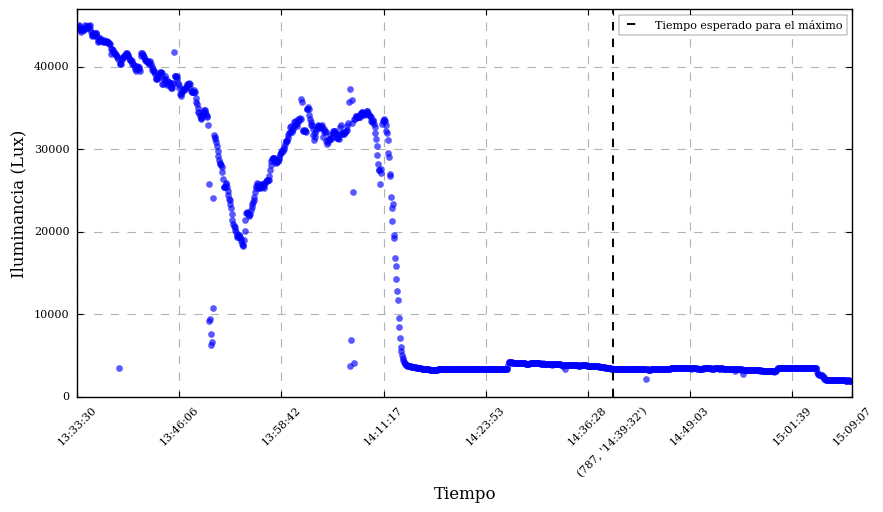

In [141]:
makeScatter(times=times, lux=lux, maximal=(787, maximal))

Podemos ver que hay bastante ruido y que poco antes de de las 14:11:17 las mediciones empiezan a caer hacia cero. Esto no se le atribuye al porcentaje de sol que ha sido cubierto, puede ser que se ocultó tras un edificio, una nube o que simplemente dejó de funcionar el sensor con el montaje que se tenía.

La baja iluminancia que se presentó entre poco después de las 13:46:06 y poco después de las 13:58:42 puede explicarse por el paso de una nube aunque, para ser precisos, no se registró juiciosamente la nubosidad durante el eclipse.

## Filtrar las mediciones

In [180]:
import numpy as np
from sklearn.svm import OneClassSVM 

+ Utilizaremos únicamente los datos antes de las 14:11:17

In [181]:
times = [(i, t) for i, t in times if t < '14:11:17']
lux = np.array(lux[:times[-1][0]])

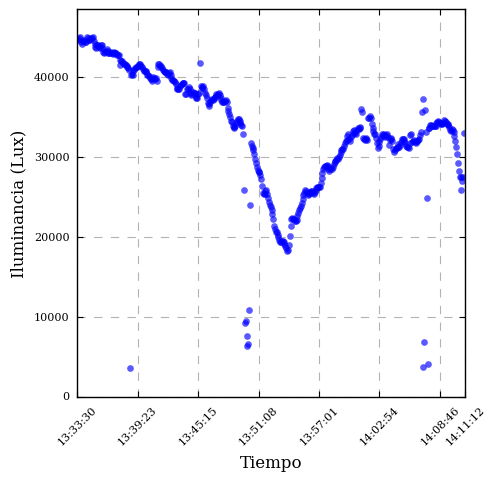

In [182]:
makeScatter(times=times, lux=lux, width=5, step=70)

+ Utilicemos Máquinas de Soporte Vectorial para encontrar valores atípicos durante las mediciones

In [183]:
clf = OneClassSVM(kernel='linear')
clf.fit(lux.reshape([-1,1]))
pred = clf.predict(lux.reshape([-1,1]))
outliers = np.array([(i, value) for i, value in enumerate(lux) if pred[i]==-1])

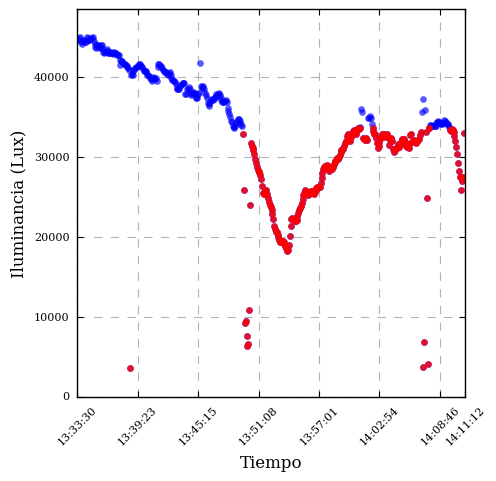

In [184]:
makeScatter(times=times, lux=lux, width=5, step=70, outliers=outliers)

## Vendrán más cosas después ...